In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats
import pandas as pd
from scipy import optimize
# from tqdm import tqdm
from scipy.special import factorial2
from scipy import special
from scipy.integrate import quad
import random
from tqdm import tqdm
import warnings
from scipy import interpolate
warnings.filterwarnings('ignore')

In [2]:
import scienceplots 
plt.style.use(['science','no-latex'])

## import data

In [3]:
option = pd.read_csv('beta00_alpha10/filtered_SSE50Option.csv')
option = option[option.Vega != 0]
option['mnes'] = option['StrikePrice']/option['close']
option['days'] = np.rint(option['TTM']*365)
option['RisklessRate'] = option['RisklessRate']/100
print(option.shape[0])
option.head()

18351


,Unnamed: 0,date,TTM,StrikePrice,close,mid_price,Vega,ImpliedVolatility,RisklessRate,mnes,days
0,0,2015-02-11,0.364384,2.45,2.38,0.1358,0.577,0.2726,0.0275,1.029412,133.0
1,1,2015-02-11,0.613699,2.45,2.38,0.1925,0.746,0.2767,0.0275,1.029412,224.0
2,2,2015-02-11,0.115068,2.20,2.38,0.2107,0.205,0.2817,0.0275,0.924370,42.0
3,3,2015-02-11,0.115068,2.25,2.38,0.1702,0.248,0.2704,0.0275,0.945378,42.0
4,4,2015-02-11,0.115068,2.30,2.38,0.1363,0.289,0.2711,0.0275,0.966387,42.0


In [4]:
## 用RV 定义高低波动
prc = pd.read_csv('Other empirics/SSE RV.csv')
prc.RV = prc.RV/100
prc.Trddt = pd.to_datetime(prc['Trddt'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
prc = prc.rename(columns={"Trddt": "Date"})
prc = prc.dropna(subset=['RV'])
prc = prc[prc.Date>'2015-02-01']
prc = prc[prc.Date<'2022-12-31']

RV = prc.copy()
# RVS = RV[RV.RV<RV.median()[0]]
# RVL = RV[RV.RV>RV.median()[0]]
RVS = RV[RV.RV<RV.RV.median()]
RVL = RV[RV.RV>RV.RV.median()]

## model-based IV

In [5]:
DN05 = pd.read_csv('beta00_alpha05/fitted_value_05.csv')
DN05 = np.array(DN05.model_price)
DN10 = pd.read_csv('beta00_alpha10/fitted_value_10.csv')
DN10 = np.array(DN10.model_price)
DN0505 = pd.read_csv('beta00_alpha0505/fitted_value_0505.csv')
DN0505 = np.array(DN0505.model_price)
DN1010 = pd.read_csv('beta00_alpha1010/fitted_value_1010.csv')
DN1010 = np.array(DN1010.model_price) 

In [6]:
option['DN05_prc'] = DN05
option['DN10_prc'] = DN10
option['DN0505_prc'] = DN0505
# option['DN0510_prc'] = DN0510
option['DN1010_prc'] = DN1010

In [7]:
import scipy.optimize as optimize
import math
from scipy.stats import norm

# Black-Scholes 定价公式（考虑连续分红率）
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    call_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

# 计算隐含波动率的函数（考虑连续分红率）
# def implied_volatility(S, K, T, r, q, market_price, option_type='call'):
#     # 定义误差函数
#     def objective_function(sigma):
#         if option_type == 'call':
#             return black_scholes_call(S, K, T, r, q, sigma) - market_price
#         else:
#             raise NotImplementedError("仅支持看涨期权")
    
#     # 使用优化器找到隐含波动率
#     result = optimize.root_scalar(objective_function, bracket=[0.0001, 1.2], method='brentq')
    
#     return result.root if result.converged else None
def implied_volatility(S, K, T, r, q, market_price, tol=1e-6, max_iterations=1000):
    # 设置初始区间
    lower_bound = 0.0001
    upper_bound = 5.0
    iteration = 0
    mid_vol = (lower_bound + upper_bound) / 2.0

    # 二分法迭代
    while iteration < max_iterations:
        mid_vol = (lower_bound + upper_bound) / 2.0
        price = black_scholes_call(S, K, T, r, q, mid_vol)
        
        # 误差达到容差范围时停止
        if abs(price - market_price) < tol:
            return mid_vol
        
        # 调整区间
        if price > market_price:
            upper_bound = mid_vol
        else:
            lower_bound = mid_vol
        
        iteration += 1

    # 如果达到最大迭代次数仍未收敛，返回 None
    return mid_vol if abs(price - market_price) < tol else None


# 示例使用
S = 100  # 标的资产价格
K = 100  # 执行价格
T = 1    # 距离到期时间（按年计算）
r = 0.05 # 无风险利率
q = 0.02 # 连续分红率
market_price = 10  # 市场期权价格

iv = implied_volatility(S, K, T, r, q, market_price)
print(f"隐含波动率: {iv:.4f}")

隐含波动率: 0.2204


In [8]:
%%time
option['DN05_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN05_prc']),axis=1)
option['DN10_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN10_prc']),axis=1)
option['DN0505_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN0505_prc']),axis=1)
option['DN1010_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN1010_prc']),axis=1)
option['market_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['mid_price']),axis=1)

CPU times: user 3min 48s, sys: 3.07 s, total: 3min 51s
Wall time: 3min 49s


In [9]:
option.head()

,Unnamed: 0,date,TTM,StrikePrice,close,mid_price,Vega,ImpliedVolatility,RisklessRate,mnes,days,DN05_prc,DN10_prc,DN0505_prc,DN1010_prc,DN05_iv,DN10_iv,DN0505_iv,DN1010_iv,market_iv
0,0,2015-02-11,0.364384,2.45,2.38,0.1358,0.577,0.2726,0.0275,1.029412,133.0,0.138716,0.140260,0.137575,0.136389,0.277664,0.280360,0.275673,0.273604,0.272574
1,1,2015-02-11,0.613699,2.45,2.38,0.1925,0.746,0.2767,0.0275,1.029412,224.0,0.191415,0.187256,0.190405,0.189864,0.275261,0.269663,0.273902,0.273172,0.276722
2,2,2015-02-11,0.115068,2.20,2.38,0.2107,0.205,0.2817,0.0275,0.924370,42.0,0.206603,0.209595,0.206239,0.205531,0.262136,0.276593,0.260324,0.256786,0.281791
3,3,2015-02-11,0.115068,2.25,2.38,0.1702,0.248,0.2704,0.0275,0.945378,42.0,0.168830,0.172571,0.168231,0.167498,0.265025,0.279740,0.262632,0.259694,0.270452
4,4,2015-02-11,0.115068,2.30,2.38,0.1363,0.289,0.2711,0.0275,0.966387,42.0,0.135232,0.139214,0.134616,0.133979,0.267467,0.281142,0.265350,0.263147,0.271148


## make plot

In [10]:
def iv_plot_by_group(option, IV_colname):
    n_points = 6
    mnes_min = 0.88
    mnes_max = 1.12
    
    DTM_con1 = (option.days<30)
    subSample = option[DTM_con1]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid1 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid1[i-1] = np.mean(subsubSample[IV_colname])
        
    
    DTM_con2 = (option.days>=30) & (option.days<90)
    subSample = option[DTM_con2]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid2 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid2[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con3 = (option.days>=90) & (option.days<180)
    subSample = option[DTM_con3]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid3 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid3[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con4 = (option.days>=180)
    subSample = option[DTM_con4]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid4 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid4[i-1] = np.mean(subsubSample[IV_colname])
        
    return mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4

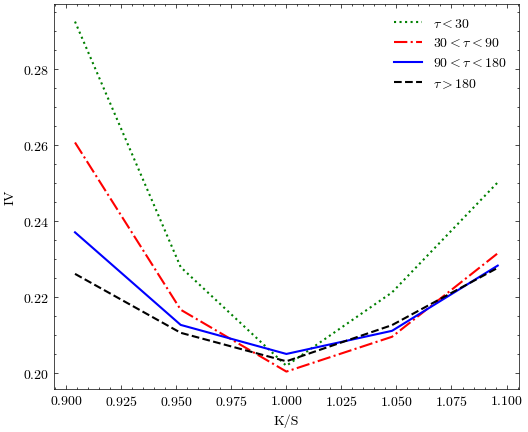

In [11]:
# optionS = option[option.date.isin(RVS.Date)]
optionS = option.copy()
mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4 = iv_plot_by_group(optionS, 'market_iv')

plt.figure(figsize=(6,5))
plt.plot(mnes_mid,iv_mid1,color='green',linestyle='dotted',label='$\\tau<30$', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2,color='red',linestyle='dashdot',label='$30<\\tau<90$', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3,color='blue',label='$90<\\tau<180$', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4,color='black',linestyle='dashed',label='$\\tau>180$', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
# plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('average_iv.eps',dpi=400)

In [12]:
def iv_plot_by_group(option, IV_colname):
    n_points = 6
    mnes_min = 0.88
    mnes_max = 1.12
    
    DTM_con1 = (option.days<30)
    subSample = option[DTM_con1]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid1 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid1[i-1] = np.mean(subsubSample[IV_colname])
        
    
    DTM_con2 = (option.days>=30) & (option.days<90)
    subSample = option[DTM_con2]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid2 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid2[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con3 = (option.days>=90) & (option.days<180)
    subSample = option[DTM_con3]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid3 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid3[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con4 = (option.days>=180)
    # subSample = option[DTM_con4]
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid4 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid4[i-1] = np.mean(subsubSample[IV_colname])
        
    return mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4

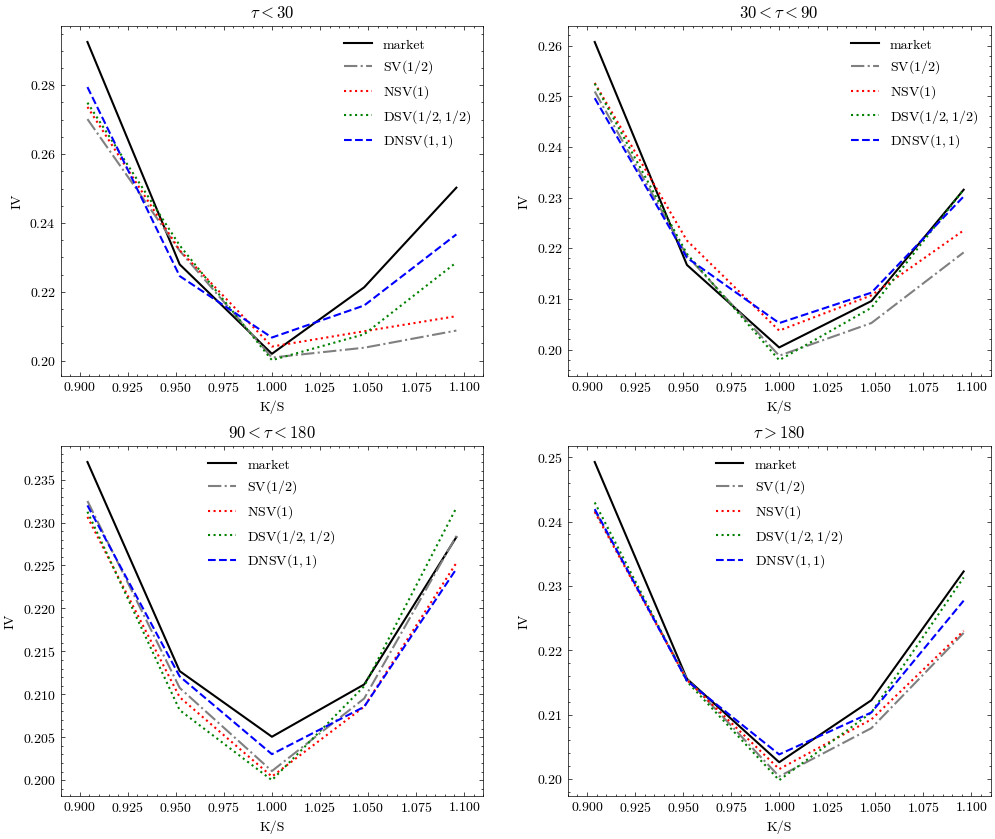

In [14]:
optionS = option.copy()
mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4 = iv_plot_by_group(optionS, 'ImpliedVolatility')
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(mnes_mid,iv_mid1,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$\\tau<30$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(222)
plt.plot(mnes_mid,iv_mid2,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$30<\\tau<90$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(223)
plt.plot(mnes_mid,iv_mid3,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$90<\\tau<180$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(224)
plt.plot(mnes_mid,iv_mid4,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$\\tau>180$')
plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('fit_average_iv.eps',dpi=400)

## make plot of ivrmse

In [15]:
def iv_plot_by_group(option, IV_colname):
    n_points = 6
    mnes_min = 0.88
    mnes_max = 1.12
    
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid1 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        # iv_mid1[i-1] = np.mean(subsubSample[IV_colname])
        iv_mid1[i-1] = np.mean(subsubSample[IV_colname]-subsubSample['market_iv'])
        
    
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid2 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        # iv_mid2[i-1] = np.mean(subsubSample[IV_colname])
        iv_mid2[i-1] = np.mean(np.abs(subsubSample[IV_colname]-subsubSample['market_iv']))
        
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid3 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        # iv_mid3[i-1] = np.mean(subsubSample[IV_colname])
        iv_mid3[i-1] = np.mean(np.abs(subsubSample[IV_colname]-subsubSample['market_iv'])/subsubSample['market_iv'])
        
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid4 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        # iv_mid4[i-1] = np.mean(subsubSample[IV_colname])
        iv_mid4[i-1] = np.sqrt(np.mean((subsubSample[IV_colname]-subsubSample['market_iv'])**2))
        
    return mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4

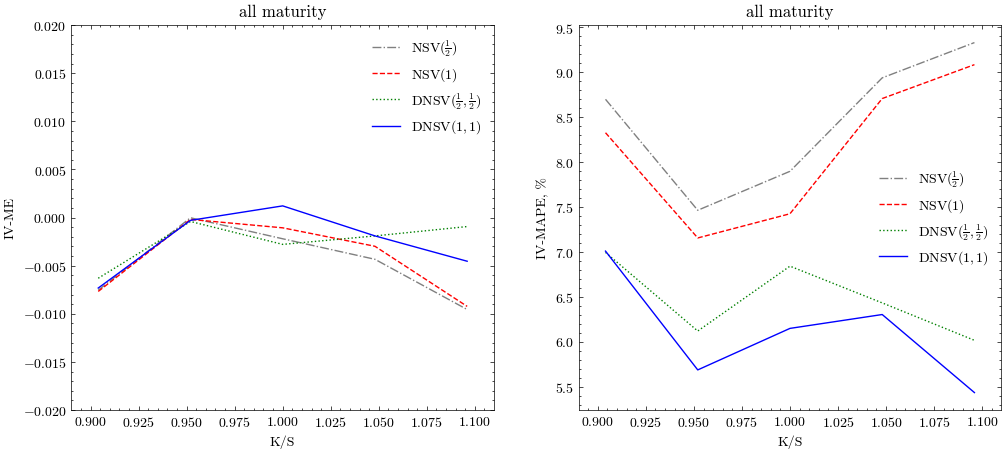

In [15]:
optionS = option.copy()
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(mnes_mid,iv_mid1_05,color='gray',linestyle='dashdot',label='SV($\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid1_10,color='red',linestyle='dashed',label='NSV($1$)')
plt.plot(mnes_mid,iv_mid1_0505,color='green',linestyle='dotted',label='DSV($\\frac{1}{2},\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid1_1010,color='blue',linestyle='-',label='DNSV($1,1$)')
plt.xlabel('K/S')
plt.ylabel('IV-ME')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.ylim([-0.02,0.02])
plt.legend()

plt.subplot(122)
plt.plot(mnes_mid,iv_mid3_05*100,color='gray',linestyle='dashdot',label='NSV($\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid3_10*100,color='red',linestyle='dashed',label='NSV($1$)')
plt.plot(mnes_mid,iv_mid3_0505*100,color='green',linestyle='dotted',label='DNSV($\\frac{1}{2},\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid3_1010*100,color='blue',linestyle='-',label='DNSV($1,1$)')
plt.xlabel('K/S')
plt.ylabel('IV-MAPE, %')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

# plt.savefig('fit_average_ivrmse.eps',dpi=400)

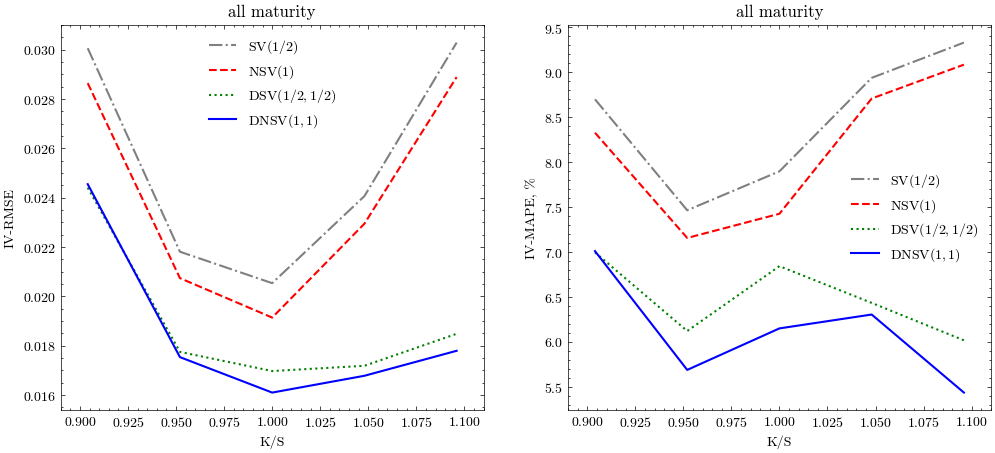

In [17]:
optionS = option.copy()
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(mnes_mid,iv_mid4_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_10,color='red',linestyle='dashed',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_1010,color='blue',linestyle='-',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV-RMSE')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(122)
# plt.plot(mnes_mid,iv_mid2_05,color='gray',linestyle='dashdot',label='NSV($\\frac{1}{2}$)')
# plt.plot(mnes_mid,iv_mid2_10,color='red',linestyle='dashed',label='NSV($1$)')
# plt.plot(mnes_mid,iv_mid2_0505,color='green',linestyle='dotted',label='DNSV($\\frac{1}{2},\\frac{1}{2}$)')
# plt.plot(mnes_mid,iv_mid2_1010,color='blue',linestyle='-',label='DNSV($1,1$)')
# plt.xlabel('K/S')
# plt.ylabel('IV-MAE')
# plt.title('all maturity')
# plt.xlim([0.89,1.11])
# plt.legend()
plt.plot(mnes_mid,iv_mid3_05*100,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_10*100,color='red',linestyle='dashed',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_0505*100,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_1010*100,color='blue',linestyle='-',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV-MAPE, %')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('fit_average_ivrmse.eps',dpi=400)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


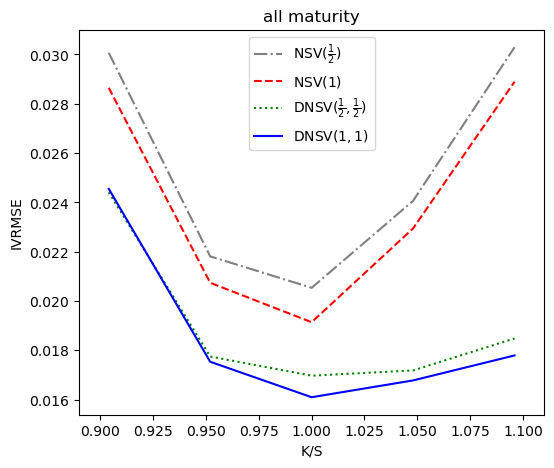

In [41]:
optionS = option.copy()
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(6,5))
plt.plot(mnes_mid,iv_mid4_05,color='gray',linestyle='dashdot',label='NSV($\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid4_10,color='red',linestyle='dashed',label='NSV($1$)')
plt.plot(mnes_mid,iv_mid4_0505,color='green',linestyle='dotted',label='DNSV($\\frac{1}{2},\\frac{1}{2}$)')
plt.plot(mnes_mid,iv_mid4_1010,color='blue',linestyle='-',label='DNSV($1,1$)')
plt.xlabel('K/S')
plt.ylabel('IVRMSE')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('fit_average_ivrmse.eps',dpi=400)